<a href="https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/Introduction_to_Fast5_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Introduction to Fast5 files</h1>

The tutorial provides a short introduction to Fast5 files used to store raw data output of Oxford Nanopore Technologies' sequencing devices. The tutorial aims to provide background information for why users may have cause to interact with Fast5 files and show how to perform common manipulations.

Methods used in this tutorial include:

* `ont_fast5_api` for manipulating read information within Fast5 files.

The computational requirements for this tutorial are:

* A computer running the EPI2ME Labs Server environment,
* 8Gb RAM.

> ⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.



## Introduction

This tutorial aims to elucidate the information stored within a Fast5 file, and how such files can be read, or parsed, within the Python programming language and on the command line.

The goals from this tutorial include:

* Understand that basic concepts of a Fast5 file,
* Know how to manipulate a Fast5 file using `ont_fast5_api`,
* Be able to compress Fast5 files and remove extraneous data,
* Be able to filter and resample Fast5 files to reads of interest.

The tutorial includes a sample Fast5 dataset from a metagenomic sample.

## Getting started

⚠️  ***Reminder:*** Connect to your locally running EPI2ME Labs Server before running any of the code below. See [Run a tutorial](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#scrollTo=r--DdCunUR6Y) on the EPI2ME Labs Server help page for more information.

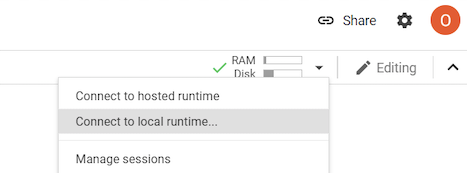

Having connected to the EPI2ME Labs Server, before anything else we will create and set a working directory:

In [ ]:
from epi2melabs import ping
tutorial_name = "fast5_tutorial"
pinger = ping.Pingu()
pinger.send_notebook_ping('start', tutorial_name)

# create a work directory and move into it
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

### Install additional software
This tutorial uses the `ont_fast5_api` software; this is not installed in the default EPI2ME Labs environment. We will install this now in an isolated manner so as to not interfere with the existing environment.

*Please note that the software installed is not persistent and this step will need to be re-run if you stop and restart the EPI2ME Labs server.*

In [ ]:
# create a conda environment and install ont_fast5_api into it
!conda create -q -y -n ont_fast5_api pip 2>/dev/null
!source /opt/conda/etc/profile.d/conda.sh \
    && conda activate ont_fast5_api \
    && which pip \
    && pip install "ont_fast5_api>=3.1.6" 

### Sample Data

In order to provide a concrete example of handling a Fast5 files this tutorial is provided with an example dataset sampled from a MinION sequencing run: the dataset is not a full MinION run in order to reduced the download size.

To download the sample file we run the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)
site = "https://ont-exd-int-s3-euwst1-epi2me-labs.s3-eu-west-1.amazonaws.com"

!rm -rf sample_fast5
!wget -O sample_fast5.tar $site/fast5_tutorial/sample_fast5.tar
!tar -xvf sample_fast5.tar
!wget -O fast5_sample.bam $site/fast5_tutorial/fast5_sample.bam
!wget -O fast5_sample.bam.bai $site/fast5_tutorial/fast5_sample.bam.bai

### Data entry

Having downloaded the sample data we need to provide the filepaths as input to the notebook.

The form can be used to enter the filenames of your inputs. Alternatively you can edit the code which reads the inputs by first double clicking the form header. After entering your inputs (or editing the code cell) remember to execute the code using `Command/Ctrl-Enter`, or pressing the `Play` symbol to the left-hand side.

In [ ]:
#@markdown Enter the paths to the input folder and output folder here.

# set variables for our inputs
input_folder = '/epi2melabs/fast5_tutorial/sample_fast5'  #@param {type: "string"}
output_folder = 'analysis'  #@param {type: "string"}

# run a command to concatenate all the files together
!cecho ok "Making output folder"
!mkdir -p "$output_folder"
!test -d "$input_folder" \
    && cecho success "Found input folder." \
    || cecho error "Input folder does not exist."
!echo " - Found "$(find "$input_folder" -name "*.fast5" | wc -l)" fast5 files"

Making output folder
Found input folder.
 - Found 5 fast5 files


Executing the above form will have checked the input folder attempted to find Fast5 files located in the folder.

## Fast5 files

Fast5 files are used by the MinKNOW instrument software and the Guppy basecalling software to store the primary sequencing data from Oxford Nanopore Technologies' sequencing devices and the results of primary and secondary analyses such as basecalling information and modified-base detection.

Before discussing how to read and manipulate Fast5 files in Python we will first review their internal structure.

###HDF5 files

Files output by the MinKNOW instrument software and the Guppy basecalling software using the `.fast5` file extension are a [container file](https://en.wikipedia.org/wiki/Container_format_(computing)) using the [HDF5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). As such they are a self-describing file with all the necessary information to correctly interpret the data they contain.

A Fast5 file differs from a generic HDF5 file in containing only a fixed, defined structure of data. This structure is elucidated in the [ont_h5_validator](https://github.com/nanoporetech/ont_h5_validator) repository on Github, specifically in the file [multi_read_fast5.yaml](https://github.com/nanoporetech/ont_h5_validator/blob/master/h5_validator/schemas/multi_read_fast5.yaml).

> *Users are referred to the YAML schemas to gain an understanding of all the data contained in Fast5 files. Users are encouraged to raise Issues on the ont_h5_validator project if the schemas are unclear. The rest of this tutorial will be mostly practical in nature.*

The schema file describes how the internal structure of a Fast5 file is laid out. There are three core concepts to understand:

1. **Groups:** an HDF group acts similarly to a folder on a computer filesystem. Hierachies of groups can exist to organise data.
2. **Datasets:** an HDF dataset contains generic data. This might range from simple text data like a Fastq record to a matrix of a complex datatype containing subfields of data.
3. **Attributes:** both groups and datasets can be labelled with attributes. These are short data items, commonly meta data, that can be used to aid understanding of the data. For example a sequencing run identifier or a timestamp.

An appreciation of these concepts is required for using the data contained within Fast5 files, though as we will see for common manipulations of Fast5 files users need only an awareness of these ideas.


### Fast5 Flavours

Historically there have been two flavours of Fast5 files:

*   Single-read files: each sequencing read was stored in a unique Fast5 file,
*   Multi-read files: multiple reads are bundled into a single Fast5 file.

The internal layout, in terms of groups and datasets, of these two flavours of Fast5 are very similar. In essence a multi-read file embeds the group hierarchy of multiple single-read files within one HDF5 container.

Single-read files are deprecated and no longer used by MinKNOW or Guppy. We recommend that any single-read files are converted to multi-read files before further use or storage, how to do this is demonstrated later in this tutorial.


### Overview of Fast5 contents

As noted above the [ont_h5_validator](https://github.com/nanoporetech/ont_h5_validator) project contains a full description of the expected contents of a Fast5 file. Here we will briefly highlight the key groups and datasets stored within a Fast5 file.

Using the dataset provided in above let's enumerate the contents of the first file using the `h5ls` program:


In [ ]:
#   i) find and list all .fast5 files
#  ii) take the first file
# iii) use `h5ls` to list the file's contents
#  iv) truncate the output to the first 19 lines
!find "$input_folder" -name "*.fast5" \
    | head -n 1 \
    | xargs h5ls -r \
    | head -n 19

/                        Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000 Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000/BaseCalled_template Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000/BaseCalled_template/Fastq Dataset {SCALAR}
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000/BaseCalled_template/Move Dataset {12212}
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000/BaseCalled_template/Trace Dataset {12212, 8}
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000/Summary Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Basecall_1D_000/Summary/basecall_1d_template Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Segmentation_000 Group
/read_00058fe1-e555-4a64-a41b-7f58fb7d6d6b/Analyses/Segmentation_000/Summary Group
/read_00058fe1-e55

The `h5ls` program can be used to display the datasets and groups of a Fast5 file. It can be used also to display attributes and more advanced properties of a file when given different options.

From the sample file we see a hierarchy of groups and datasets. The highest of these is a group indicating a read together with the unique identifier of the read. Under this top level read group we have:

* `Analyses`: contains derived datasets such as basecalling information,
* `Raw`: the raw sequencer output, measurements of the ionic current through a nanopore as a function of time.
* `channel_id`: information such as channel number and ASIC sampling rate
* `context_tags`: information provided at runtime such as experiment type
* `tracking_id`: information such as the unique run identified, flowcell identifier, and computer name. 

*For a full description of these fields see the documentation on the [Nanopore Community](https://community.nanoporetech.com/technical_documents/data-analysis).*

For files generated by MinKNOW without live basecalling enabled, the `Analyses` section will be absent (or contain no subgroups). The sample file is one that has been created by Guppy using the `--fast5_out` option to produce Fast5 files in addition to `.fastq.gz` files containing solely the basecalls. The `Analyses` section listed above therefore contains two subgroups: `Segmentation_000` and `Basecall_1D_000`. The first of these contains information regarding how a read as been trimmed by the basecaller into seqeuncing adapter and, barcode and insert regions. The second contains the basecaller outputs, primarily the `Fastq` dataset but also two additional groups `Move` and `Trace` which contain advanced basecaller outputs. Again see the documentation in the Nanopore Community for a full description of these.

### An aside on file indexing and compression

The Fast5 files from a MinION run can become fairly sizeable, up to a few hundred gigabytes. Efficient and performant compression and indexing is therefore required.

#### Indexing reads

For the most part the self describing and indexed nature of the HDF5 format ensures that data within a file can be quickly retrieved. However for a MinION run multiple Fast5 files are created each with a subset of the sequencing reads produced by the sequencer. Therefore finding the information pertaining to a read of a known ID cannot be done without a supplementary index cross-referencing the reads contained within in file; the alternative is to open all the files in turn and enquire about their contents. ***The `sequencing_summary.txt` file produced by both MinKNOW and Guppy provides an index of the reads contained within in each Fast5 file***. This index can of course be reconstructed if required (as in the case of [nanopolish index](https://github.com/jts/nanopolish)), though we recommend always storing the sequencing summary with the Fast5 data files.

#### File compression

Due to the large volume of data created by nanopore sequencing devices Oxford Nanopore Technologies has developed a bespoke compression scheme for ionic current trace data known as [VBZ](https://github.com/nanoporetech/vbz_compression). VBZ is a combination of two open compression algorithms and is itself open and freely available from the Github [release page](https://github.com/nanoporetech/vbz_compression/releases/latest). Ordinarily it will not be necessary to install the VBZ compression library and HDF5 plugin to simply use MinKNOW and Guppy as these software applications include their own copy of VBZ. However if you wish to read Fast5 files using third party applications (such as [h5py](https://pypi.org/project/h5py/)) you will need to install the VBZ plugin.

## Manipulating Fast5 files

The section above has given an outline to the data contained within a Fast5 file and how the file is arranged. Again for a more fulsome description of the contents of files users are directed to the [ont_h5_validator](https://github.com/nanoporetech/ont_h5_validator) project. In this section we will highlight several methods for manipulating the data contained within Fast5 files.

Oxford Nanopore Technologies provides a Python-based software for accessing data stored within a set of Fast5 files: [ont_fast5_api](https://github.com/nanoporetech/ont_fast5_api). For the most part this set of tools hides from the user the need to understand anything about the nature of Fast5 files. Here we will show how to perform some common tasks that might be required when dealing with Fast5 files. For a guide in using `ont_fast5_api` programmatically please see the [documention](https://github.com/nanoporetech/ont_fast5_api#interface---get_fast5_file).

### Converting multi-read files to single-read files

Since some older programs have not been updated to use multi-read files it can sometimes be necessary to convert such files to the deprecated single-read flavour. To do this run:

In [ ]:
!rm -rf $output_folder/single-reads
!run multi_to_single_fast5 \
    --input_path $input_folder --save_path $output_folder/single-reads \
    --recursive

| 5 of 5|####################################################|100% Time: 0:00:34


The output of the above command is a set of folders each containing a subset of the sequencing reads, one read per file. The filename of each read corresponds to the read's unique identifier.

In [ ]:
!ls $output_folder/single-reads/0 2>/dev/null | head -n 5

00058fe1-e555-4a64-a41b-7f58fb7d6d6b.fast5
000dd482-c0d5-4520-aa86-8ee8bb61fd58.fast5
00158d74-4b7f-445a-b0ac-e1606f6c09b7.fast5
004a0bd2-edcf-4c2c-89bc-009a232cdb6a.fast5
0057b9d1-e566-4518-8b81-f69b30c6da99.fast5


### Converting single-read to multi-read files

A similar program exists to convert single-read files to multi-read files. We recommend that all datasets are updated to multi-read files for longer term storage. Here we will convert the single-reads created above back to multi-read files:

In [ ]:
!rm -rf $output_folder/multi-reads
!run single_to_multi_fast5 \
    --input_path $output_folder/single-reads --save_path $output_folder/multi-reads \
    --filename_base prefix --batch_size 8000 --recursive

| 3 of 3|####################################################|100% Time: 0:00:55


The output of this command is a single directory containing all multi-read files. The filenames are prefixed with `prefix` as taken by the `--filename_base` argument of the program. The `--batch_size` argument here controls the number of reads per file:

In [ ]:
!ls $output_folder/multi-reads

filename_mapping.txt  prefix_0.fast5  prefix_1.fast5  prefix_2.fast5


The `filename_mapping.txt` cross-references the data from the input files with the output files.

In [ ]:
!head $output_folder/multi-reads/filename_mapping.txt

26cb0f7d-8db2-4e2d-aa4e-9d273ccf1d66.fast5	analysis/multi-reads/prefix_0.fast5
b4441e24-a5d3-4357-bc24-4a169520d096.fast5	analysis/multi-reads/prefix_0.fast5
5d63b4ae-e9c7-43cb-b73c-7b3bc7facd57.fast5	analysis/multi-reads/prefix_0.fast5
5880c8b8-5c67-45cd-9082-2be09a7fc1d4.fast5	analysis/multi-reads/prefix_0.fast5
77d557c6-2154-4792-ad2d-49c9ca5f4bdd.fast5	analysis/multi-reads/prefix_0.fast5
afa10699-8648-4e7a-8bec-86118f202e8d.fast5	analysis/multi-reads/prefix_0.fast5
fb15566d-370c-478e-a190-d4221407e500.fast5	analysis/multi-reads/prefix_0.fast5
34465bd4-2335-4390-8675-daef5390ea79.fast5	analysis/multi-reads/prefix_0.fast5
67b3c07c-c4db-40e9-a18b-c10c8eeb70f5.fast5	analysis/multi-reads/prefix_0.fast5
133ac0a7-54d4-4681-8653-49b174fe6e7c.fast5	analysis/multi-reads/prefix_0.fast5


### Creating a listing of reads within multi-read files

As mentioned in the discussion above it can be useful to have an index of which reads are contained within which multi-read files. Usually this indexing is provided by the `sequencing_summary.txt` file output by MinKNOW and Guppy. However if it is lost, here's a way to recover the information:

In [ ]:
# build a script that will do the work
with open("build_read_index.sh", 'w') as fh:
    fh.write(
        '''
        echo -e "filename\tread_id"
        find $1 -name "*.fast5" \\
        | parallel --tag h5ls -f -r \\
        | grep "read_.\{8\}-.\{4\}-.\{4\}-.\{4\}-.\{12\} Group" \\
        | sed "s# Group##" | sed "s#/read_##"
        ''')
# run the script
!bash build_read_index.sh $input_folder > read_index.txt

The `read_index.txt` output file contains the simple index we desire:

In [ ]:
!head read_index.txt

filename	read_id
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_400.fast5	00085dbe-217a-40f2-90c0-3bb15669f32c
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_400.fast5	00237911-92b3-49b4-9d13-2ea6a2ded996
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_400.fast5	0025338c-3ea8-4168-b999-fe7f7fd597ee
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_400.fast5	00408494-e245-401e-8c9a-575ee491971b
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_400.fast5	00485ea4-a2fc-4b75-9969-9f1b1ab997da
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_400.fast5	004fbd46-3565-4505-8ade-bfa5bffa499b
/epi2melabs/fast5-tutorial/sample_fast5/workspace/FAK42335_2bf4f211a2e2d04662e50f27448cfd99dafbd7ee_4

### Filtering multi-reads by reference locus

The program `fast5_subset` within `ont_fast5_api` can be used to create a new file set containing only a subset of reads.

The sample data contains data from a microbial mock community. Using the accompanying BAM alignment file lets find the reads with align to a single reference sequence:

In [ ]:
!rm -rf read_list.txt
!echo "read_id" > read_list.txt
!samtools view fast5_sample.bam lfermentum \
    | awk '{print $1}' \
    | tee -a read_list.txt \
    | echo "Found" $(wc -l) "reads"

Found 1100 reads


We can now use this file with the subsetting program:

In [ ]:
!echo $input_folder
!rm -rf $output_folder/lfermentum
!run fast5_subset --input $input_folder --save_path $output_folder/lfermentum \
    --read_id_list read_list.txt --batch_size 8000 --recursive

/epi2melabs/fast5_tutorial/sample_fast5
| 1105 of 1105|##############################################|100% Time: 0:00:02
INFO:Fast5Filter:1100 reads extracted


### Cleaning multi-read files of `Analyses` groups

It can be the case that it is desirable to remove the `Analyses` groups from multi-read files. For example if live basecalling were performed during a run but these results are not wanted before data is archived.

To accomplish this task we will use the `compress_fast5` program with the `--sanitize` option:

In [ ]:
!rm -rf $output_folder/sanitized
!run compress_fast5 --input_path $input_folder --save_path $output_folder/sanitize \
    --compression vbz --recursive --threads 8 --sanitize

| 5 of 5|####################################################|100% Time: 0:00:12


This achieves an approximate 3.5X reduction in filesize:

In [ ]:
!du -sh $input_folder $output_folder/sanitize

2.4G	/epi2melabs/fast5_tutorial/sample_fast5
682M	analysis/sanitize


## Summary

In this notebook we have introduced the Variant Call Format with an examplar file from the Medaka consensus and variant calling program. We have outlined the contents of such files and how they can be intepreted with a selection of common software packages.

The code tools presented here can be run on any dataset from an Oxford Nanopore Technologies' device. The code will run within **Google Colab** when connected to a local **EPI2ME Labs** notebook server.

[Back to EPI2ME Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
